# 傾向スコアを用いた TV CM の視聴によるゲーム利用傾向の変化の分析

In [113]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import sys, os
sys.path.append('..')

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [115]:
from pycalf import PropensityScore
from pycalf import metrics

まずはじめに、サンプルデータを取得する。

In [116]:
df = pd.read_csv('sample/q_data_x.csv')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cm_dummy         10000 non-null  int64  
 1   gamedummy        10000 non-null  int64  
 2   area_kanto       10000 non-null  int64  
 3   area_keihan      10000 non-null  int64  
 4   area_tokai       10000 non-null  int64  
 5   area_keihanshin  10000 non-null  int64  
 6   age              10000 non-null  float64
 7   sex              10000 non-null  int64  
 8   marry_dummy      10000 non-null  int64  
 9   job_dummy1       10000 non-null  int64  
 10  job_dummy2       10000 non-null  int64  
 11  job_dummy3       10000 non-null  int64  
 12  job_dummy4       10000 non-null  int64  
 13  job_dummy5       10000 non-null  int64  
 14  job_dummy6       10000 non-null  int64  
 15  job_dummy7       10000 non-null  int64  
 16  job_dummy8       10000 non-null  int64  
 17  inc          

In [118]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


次に、共変量・結果変数・介入変数を指定し、モデルを定義する。

In [119]:
# Define variables required for inference.
covariate_cols = [
    'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney',
    'area_kanto', 'area_tokai', 'area_keihanshin', 'job_dummy1', 'job_dummy2',
    'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
    'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'
]
outcome_cols = ['gamecount', 'gamedummy', 'gamesecond']
treatment_col = 'cm_dummy'

In [124]:
# Set Values from dataframe.
X = df[covariate_cols]
y = df[outcome_cols]
treatment = df[treatment_col]

# Scaling Raw Data.
scaler = preprocessing.MinMaxScaler()
scaled_X = scaler.fit_transform(X)

### VIF を用いた多重共線性の確認

In [132]:
vif = metrics.VIF()
vif.fit(pd.DataFrame(scaled_X, columns=covariate_cols))

vif.transform()

,VIF
TVwatch_day,2.26
age,8.49*
sex,4.88
marry_dummy,8.75*
child_dummy,4.25
inc,10.01*
pmoney,2.68
area_kanto,1.18
area_tokai,1.23
area_keihanshin,1.37


In [7]:
# Define IPW Class.
learner = LogisticRegression(** {
    'solver': 'lbfgs',
    'max_iter': 1000,
    'random_state': 42
})
model = PropensityScore.IPW(learner)

# Fit model.
model.fit(scaled_X, treatment)

### 効果量dを用いた調整後の共変量ばらつき

IPW によって、共変量のばらつきが調整されたのかを効果量を用いて確認する。

In [8]:
std_diff = metrics.StandardDiff()
d_values = std_diff.fit_transform(X, treatment, weight=model.weight)
# MEMO: 以下は、調整前の共変料のばらつき
# d_values = std_diff.fit_transform(X, treatment, weight=np.ones(model.weight.shape))

fam_str_dummy4     0.001776
job_dummy3         0.002827
pmoney             0.003229
job_dummy6         0.007447
job_dummy4         0.011206
child_dummy        0.011945
fam_str_dummy2     0.013479
area_keihanshin    0.014269
area_kanto         0.027226
marry_dummy        0.029342
job_dummy2         0.031765
sex                0.046159
job_dummy7         0.050544
job_dummy5         0.058377
fam_str_dummy1     0.061587
fam_str_dummy3     0.063502
age                0.070874
inc                0.071864
job_dummy1         0.081352
TVwatch_day        0.138465
area_tokai         0.145181
dtype: float64

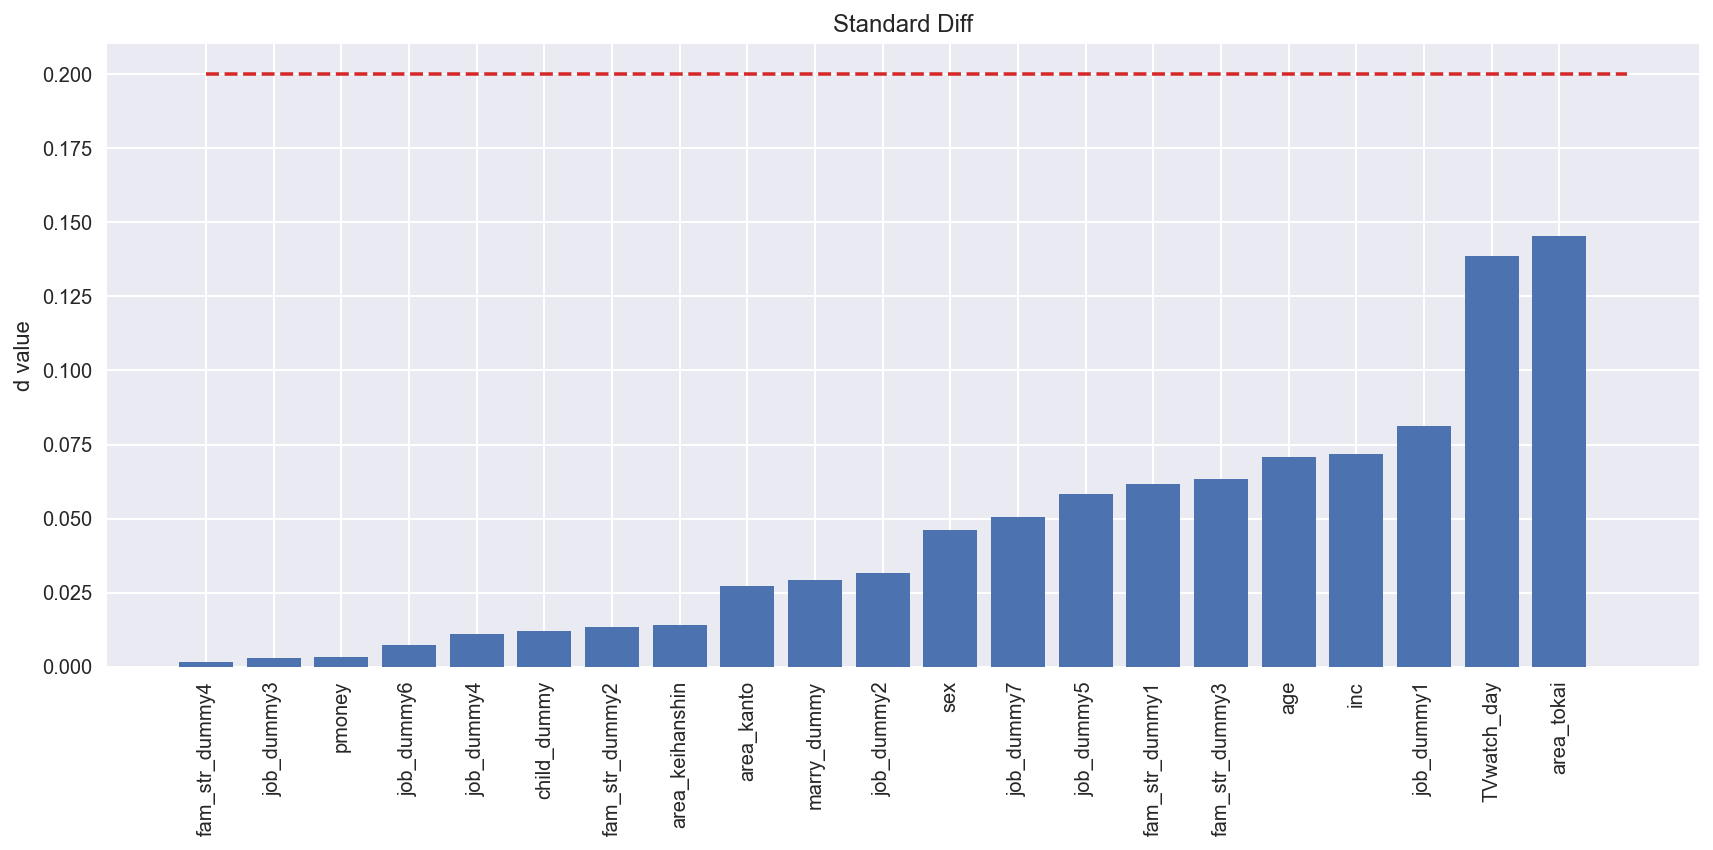

In [9]:
display(d_values)
std_diff.plot_d_values()

### AUC と 傾向スコアの分布の可視化

ここでは、AUC と 介入有無別の傾向スコアの分布を可視化する。

AUC は、0.7 以上であることが好ましいとされる。
参考：https://www.jstage.jst.go.jp/article/tenrikiyo/19/2/19_19-008/_pdf

介入有無別の傾向スコアの分布は、ある程度重なりが有りながら介入有無別の分布が別れているので傾向スコアによる調整が行えるように見える。

AUC: 0.7913


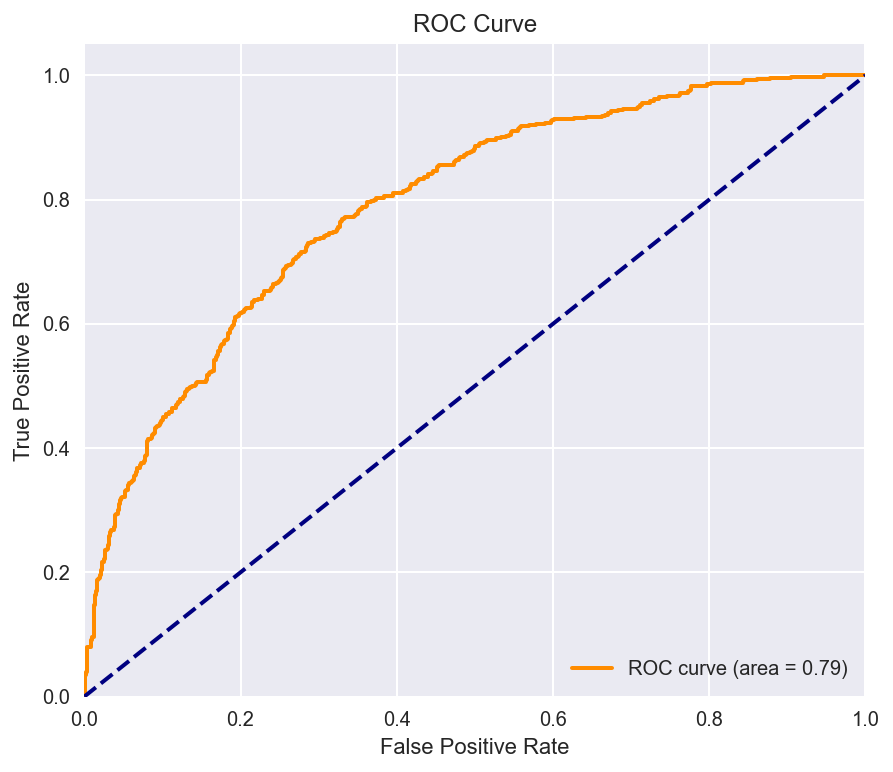

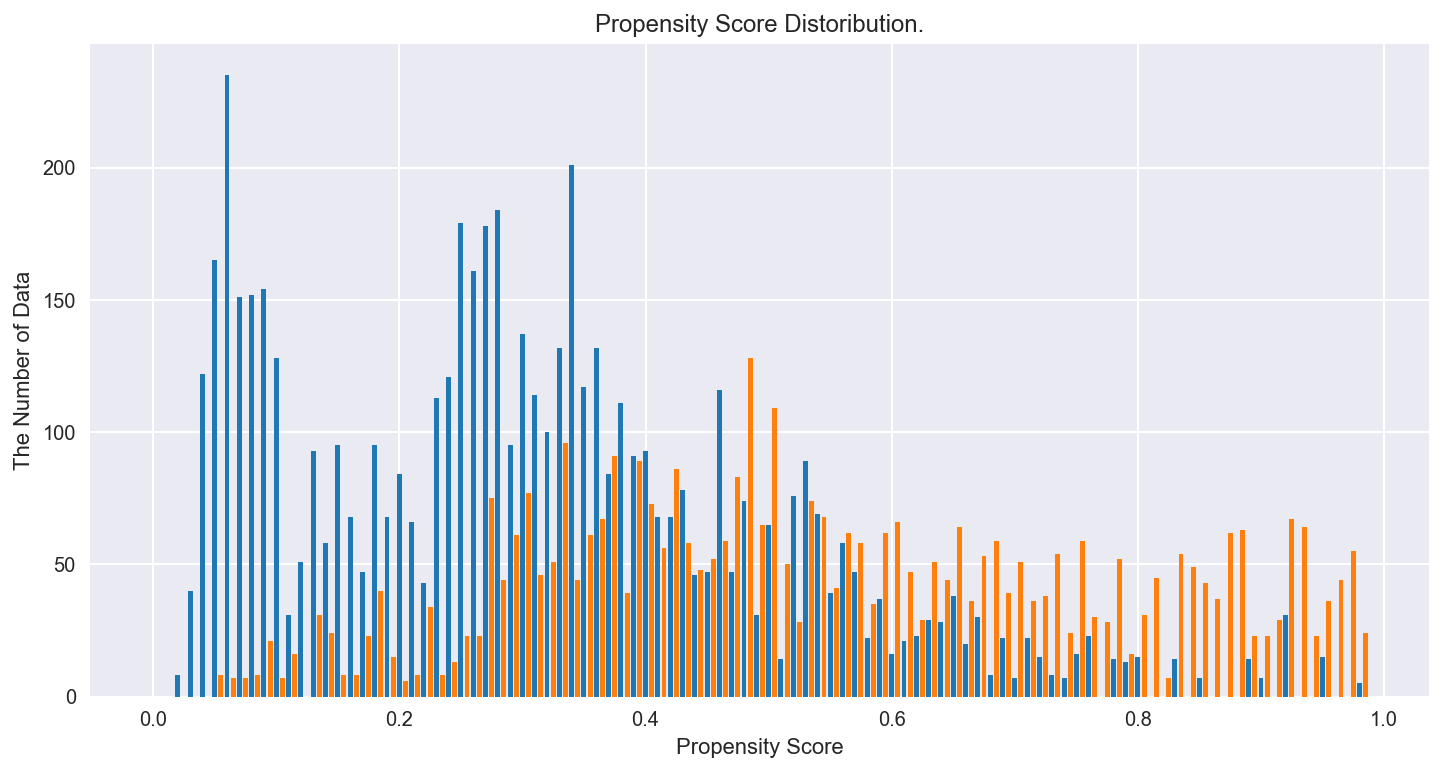

In [10]:
print(f'AUC: {model.acu(treatment):.04}')

model.plot_roc_curve(treatment)
model.plot_propensity_score(treatment)

### 平均処置効果（ATE: Average Treated Effect）

IPW による調整後の介入効果

In [11]:
print('ATE:')
display(model.estimate_ate(treatment, y))

# ATT: 
# model.estimate_att(treatment, y)
# ATU: 
# model.estimate_atu(treatment, y)

# Intervention effect before adjustment:
# model.raw_effect(treatment, y)

ATE:


,Z0,Z1,ATE
gamecount,8.48837,13.1217,4.63332
gamedummy,0.0635441,0.0930106,0.0294665
gamesecond,2691.41,3959.16,1267.75


### 属性変数を用いた介入効果の推定

,Z0_effect,Z0_tvalue,Z1_effect,Z1_tvalue,Lift
M1,5816.2,9.12**,176.1,0.22,-5640.1
child_dummy,1801.7,3.5**,-1723.0,-2.65**,-3524.7
area_tokai,2120.6,3.62**,-1322.4,-1.51,-3443.0
area_kanto,1967.6,2.59**,-957.2,-1.03,-2924.8
F1,-974.5,-1.51,-2180.5,-2.42**,-1206.0
T,5814.6,2.77**,5000.5,2.0**,-814.1
area_keihan,1998.2,5.22**,1760.0,3.58**,-238.2
M3,-1345.2,-2.36**,-1209.9,-1.61,135.3
F2,-347.2,-0.52,-113.4,-0.15,233.8
F3,-1645.0,-1.94,-1283.1,-1.04,361.9


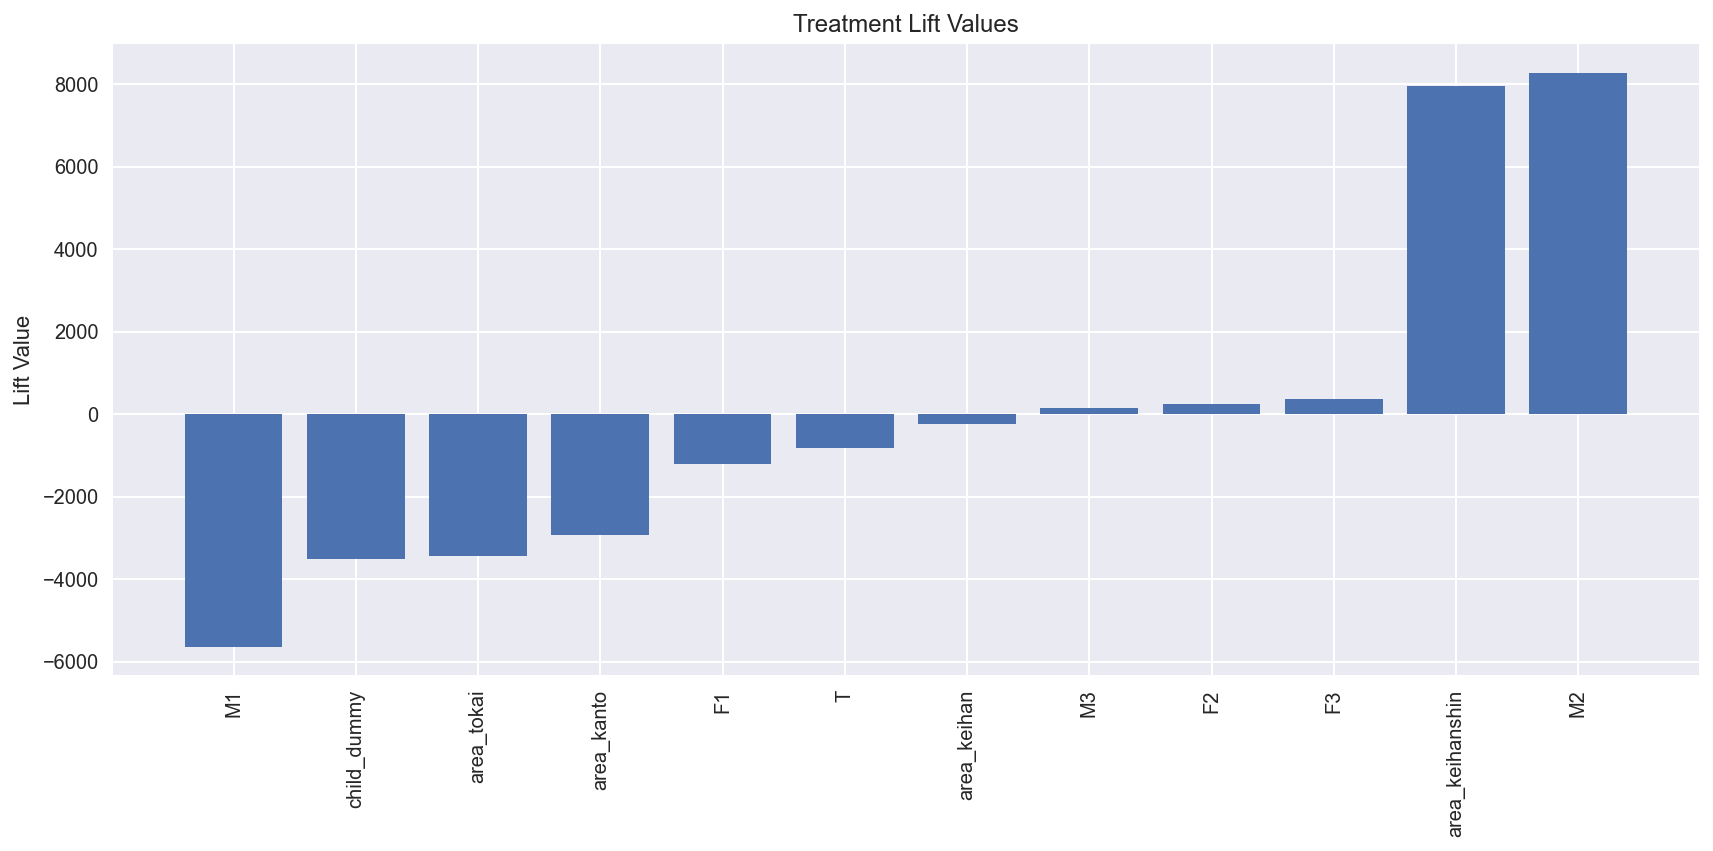

In [12]:
# Attribute Effect
treatment_col = 'cm_dummy'
y = 'gamesecond'
features = [
    'child_dummy', 'area_kanto', 'area_keihan', 'area_tokai', 'area_keihanshin',
    'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3'
]

attr_effect = metrics.AttributeEffect()
attr_effect.fit(df[features], df[treatment_col], df[y], weight=model.weight)
result = attr_effect.transform()

display(result)
attr_effect.plot_lift_values()